In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from cv_master import SatelliteImageData, Grid2DKernel

sns.set_style('whitegrid')

In [14]:
kernel = Grid2DKernel(55, 55)
data = SatelliteImageData(kernel)
df = data.df
df.reset_index(inplace=True)
df['log(sd)'] = np.log(df.sd)
df.label = df.label.map({1: 1, 0: -1, 2: 0})

col_names = [
    ('label', 'Expert Label'),
    ('ndai', 'NDAI'),
    ('sd', 'SD'),
    ('corr', 'CORR'),
    ('ra_df', 'Radiance angle DF'),
    ('ra_cf', 'Radiance angle CF'),
    ('ra_bf', 'Radiance angle BF'),
    ('ra_af', 'Radiance angle AF'),
    ('ra_an', 'Radiance angle AN'),
]

In [46]:
def wrap_index(i, n, axis=0):
    if axis == 0:
        return i%n, i//n
    else:
        return i//n, i%n

def get_heatmap_data(df, col):
    return df[['y', 'x', col]].set_index(['y', 'x']).unstack()

def plot_heatmap(data, label, cmap, ax):
    sns.heatmap(data, cmap=cmap, ax=ax)
    ax.tick_params(
        left = False, right = False , labelleft = False,
        labelbottom = False, bottom = False
    )
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_title(label)

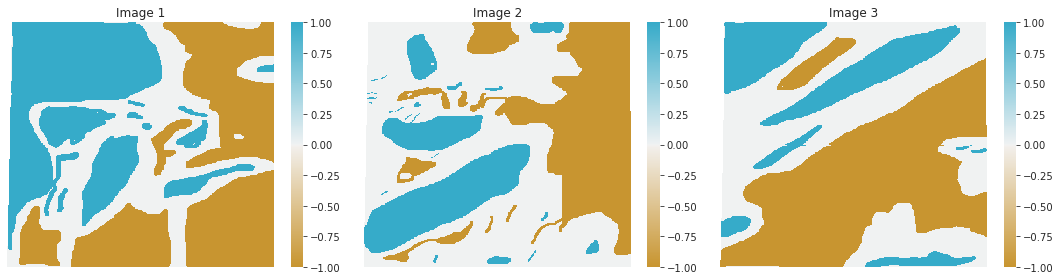

In [51]:
fig, ax = plt.subplots(1, 3, figsize=(5*3, 4))

# universial divergent color map
cmap = sns.diverging_palette(55, 220, s=90, l=65, as_cmap=True)

for i in range(3):
    ax_i = ax[i]
    plot_heatmap(get_heatmap_data(df[df.image==i], 'label'), label=f'Image {i+1}', cmap=cmap, ax=ax_i)

fig.tight_layout()
fig.show()

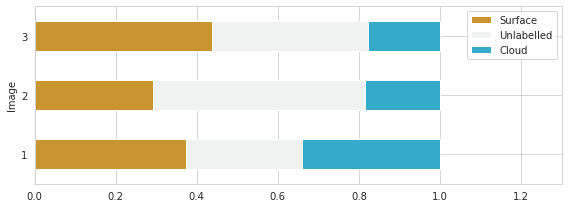

In [52]:
fig, ax = plt.subplots(figsize=(8, 3))

sr = df.groupby('image').label.value_counts(normalize=True)
sr.index.names = ['image','y']
sr = sr.unstack()
sr.index = sr.index.map({0: 1, 1: 2, 2: 3})
sr.columns = sr.columns.map({-1: 'Surface', 0: 'Unlabelled', 1: 'Cloud'})

sr.plot.barh(stacked=True, ax=ax, colormap=cmap)
ax.set_xlim(0, 1.3)
ax.set_ylabel('Image')
ax.legend(title='')

fig.tight_layout()
fig.show()

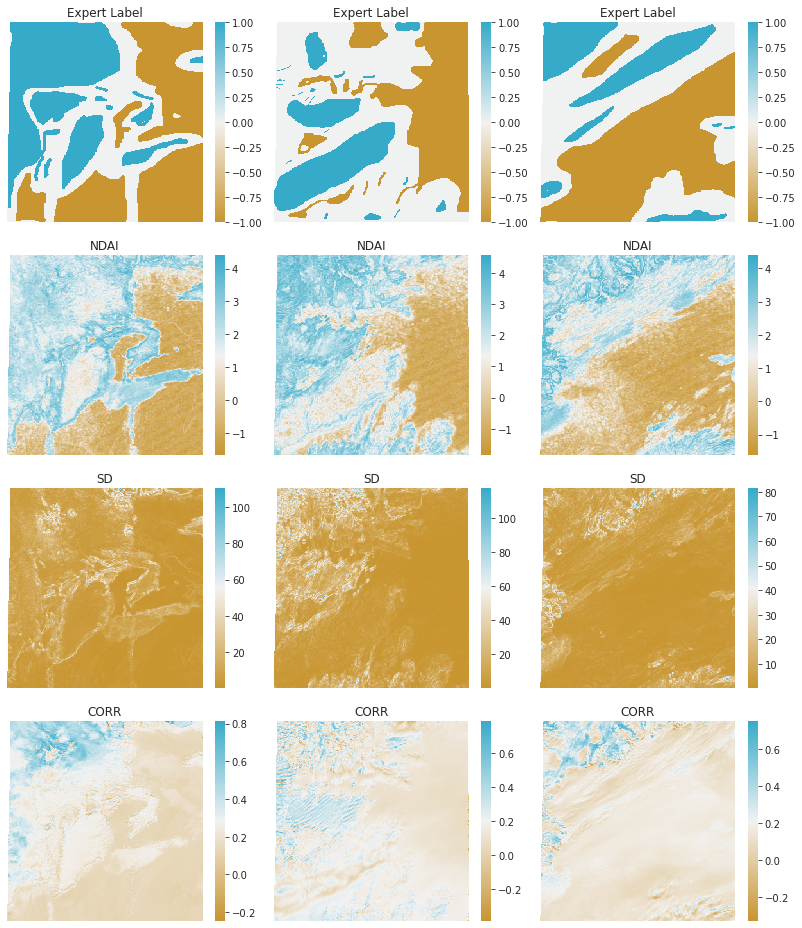

In [50]:
# universial divergent color map
# cmap = sns.diverging_palette(220, 20, as_cmap=True)
cmap = sns.diverging_palette(55, 220, s=90, l=65, as_cmap=True)

# setting up plot grid
nrow, ncol = 4, 3
fig, ax = plt.subplots(nrow, ncol, figsize=(3.75*ncol, 3.25*nrow))

# plotting each feature to its subplot
for k in range(3):
    for i, (col, label) in enumerate(col_names[:4]):
        ax_ij = ax[wrap_index(i+(k*nrow), nrow, axis=0)]
        plot_heatmap(get_heatmap_data(df[df.image==k], col), label=label, cmap=cmap, ax=ax_ij)

# some clean up
# fig.delaxes(ax[nrow-1, ncol-1])
fig.tight_layout()
fig.show()

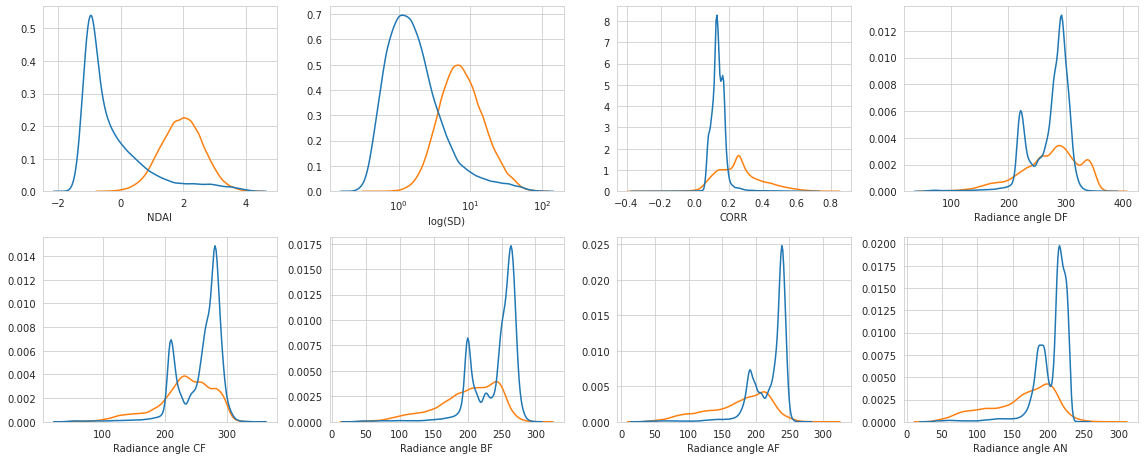

In [53]:
def plot_feature_by_label(df, feature, log_scale=False, ax=None):
    return sns.kdeplot(
        data=df, x=feature, hue='label', log_scale=log_scale,
        palette=sns.color_palette("tab10", n_colors=2), hue_order=[-1,1], ax=ax
    )

# setting up plot grid
to_plot = df[df.label!=0]
nrow, ncol = 2, 4
fig, ax = plt.subplots(nrow, ncol, figsize=(4*ncol, 3.25*nrow))

# plotting each feature to its subplot
for i, (col, label) in enumerate(col_names[1:]):
    ax_ij = ax[wrap_index(i, ncol, axis=1)]
    if col == 'sd':
        plot_feature_by_label(to_plot, col, log_scale=True, ax=ax_ij)
        label = 'log(SD)'
    else:
        plot_feature_by_label(to_plot, col, log_scale=False, ax=ax_ij)

    ax_ij.set_xlabel(label)
    ax_ij.set_ylabel("")
    ax_ij.get_legend().remove()

fig.tight_layout()
fig.show()

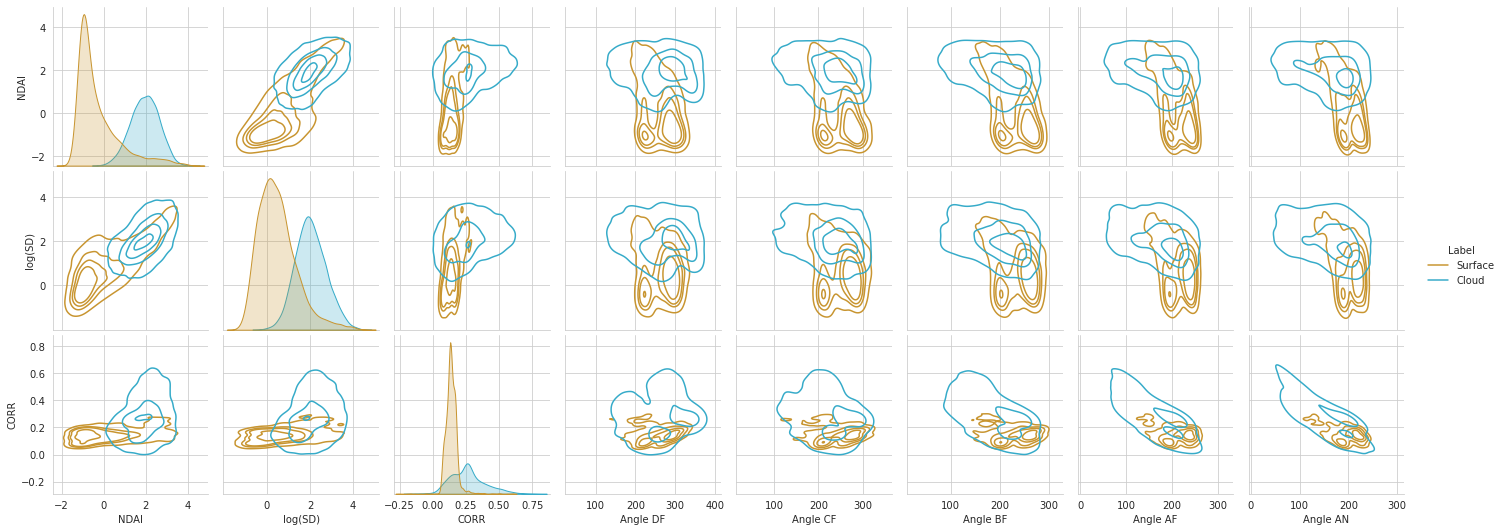

In [54]:
to_plot = df[df.label!=0].sample(10000)
to_plot['label'] = to_plot.label.map({-1: 'Surface', 1: 'Cloud'})

grid = sns.pairplot(
    data=to_plot,
    y_vars=['ndai', 'log(sd)', 'corr'],
    x_vars=['ndai', 'log(sd)', 'corr', 'ra_df', 'ra_cf', 'ra_bf', 'ra_af', 'ra_an'],
    kind='kde', hue='label',
    palette=sns.diverging_palette(55, 220, s=90, l=65, n=2), hue_order=['Surface', 'Cloud'],
    plot_kws={'levels': 5}
)

label_mapper = dict([
    ('ndai', 'NDAI'),
    ('log(sd)', 'log(SD)'),
    ('corr', 'CORR'),
    ('ra_df', 'Angle DF'),
    ('ra_cf', 'Angle CF'),
    ('ra_bf', 'Angle BF'),
    ('ra_af', 'Angle AF'),
    ('ra_an', 'Angle AN'),
])

for col in grid.axes:
    for ax in col:
        if ax.get_xlabel() != '':
            ax.set_xlabel(label_mapper[ax.get_xlabel()])
        
        if ax.get_ylabel() != '':
            ax.set_ylabel(label_mapper[ax.get_ylabel()])

grid.legend.set_title('Label')